In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import numpy as np
import math
import warnings
import missingno as msno
from pprint import pprint
from chinese_calendar import is_workday, is_holiday
from pathlib import Path
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
from collections import defaultdict

# 固定随机种子，稳定模型效果
random.seed(2021) 
np.random.seed(2021)
%matplotlib inline
warnings.filterwarnings("ignore")
plt.rc("font",family="SimHei",size="10")
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',200)
pd.set_option('expand_frame_repr', False)

In [2]:
# 数据集路径
root = Path(os.getcwd()).resolve().parent / "data"
root2 = Path(os.getcwd()).resolve().parent / "pic"
train = root / "附件1：估价训练数据.txt"
test = root / "附件2：估价验证数据.txt"

# index2name存放的是所有特征的名称
index2name = ["车辆 id", "展销时间", "品牌 id", "车系 id", "车型 id", "里程", "车辆颜色", "车辆所在城市 id", "国标码",
              "过户次数", "载客人数", "注册日期", "上牌日期", "国别", "厂商类型", "年款", "排量", "变速箱", "燃油类型",
              "新车价"]

# category存放的是类别特征的名称
category = ["品牌 id", "车系 id", "车型 id", "车辆颜色", "车辆所在城市 id", "厂商类型", "燃油类型"] # 类别类型特征

# numerical存放的是数值特征的名称
numerical = ["Feature_5", "年款", "排量", "变速箱", "Feature_2", "Feature_13", "载客人数", "新车价", "里程"] #  "厂商类型"实数类型特征, "Feature_12", "Feature_8"

# cross_num存放的是要进行特征交叉的特征的名称
cross_num = ["新车价", "Feature_2", "Feature_12_1"]

# 匿名特征为Feature_i，此处将15个匿名特征加入到index2name中
for _ in range(1, 16):
    index2name.append("Feature_"+str(_))
index2name.append("target")

In [3]:
# i2n函数：将dataframe的header改为index2name
def i2n(df):
    df = df.rename(columns={index: _ for index, _ in enumerate(index2name)})
    return df

# metric为比赛设定的模型评价指标
def metric(y_, y):
    ape = np.abs(y_ - y) / y
    mape = np.mean(ape)
    accuracy = np.sum(ape <= 0.05) / len(ape)
    # print(f"mape: {float(1 - mape)} accuracy: {float(accuracy)}")
    return float(0.2 * (1 - mape) + 0.8 * accuracy)

In [4]:
# 读取数据集
data_df = pd.read_csv(train, sep="\t", header=None)
data_df = i2n(data_df)
test_df = pd.read_csv(test, sep="\t", header=None)
test_df = i2n(test_df)

# 将target==10900的那条数据删除
data_df = data_df[data_df["target"] <= 10000]
# data_df = data_df[((data_df["新车价"]-data_df["target"]) / data_df["新车价"]) < 0.969]
# data_df = data_df[data_df["新车价"] > data_df["target"]]

# 将data_df打乱
data_df.sort_values(by="展销时间")

# 将时间转为datetime类型，便于之后的特征工作
data_df["展销时间"] = pd.to_datetime(data_df["展销时间"])
data_df["注册日期"] = pd.to_datetime(data_df["注册日期"])
data_df["上牌日期"] = pd.to_datetime(data_df["上牌日期"])
# =========================================================
test_df["展销时间"] = pd.to_datetime(test_df["展销时间"])
test_df["注册日期"] = pd.to_datetime(test_df["注册日期"])
test_df["上牌日期"] = pd.to_datetime(test_df["上牌日期"])


# 这里做了两个筛除异常数据的操作：1. 将target过低的数据删除，主要考虑是一些车况很差的数据，并不多见。2.将target比新车价高的数据删除，这些数据有可能是一些绝版车的数据，不多见。
tr = data_df
tr = tr.sample(len(tr))
tr = tr[((tr["新车价"]-tr["target"]) / tr["新车价"]) < 0.969]
tr = tr[tr["新车价"] > tr["target"]]
# te = data_df.iloc[tr_size:]
te = test_df

In [4]:
# 读取数据集
data_df = pd.read_csv(train, sep="\t", header=None)
data_df = i2n(data_df)
# 将target==10900的那条数据删除
data_df = data_df[data_df["target"] <= 10000]
# data_df = data_df[((data_df["新车价"]-data_df["target"]) / data_df["新车价"]) < 0.969]
# data_df = data_df[data_df["新车价"] > data_df["target"]]

# 将data_df打乱
data_df.sort_values(by="展销时间", inplace=True)

# 将时间转为datetime类型，便于之后的特征工作
data_df["展销时间"] = pd.to_datetime(data_df["展销时间"])
data_df["注册日期"] = pd.to_datetime(data_df["注册日期"])
data_df["上牌日期"] = pd.to_datetime(data_df["上牌日期"])

# ds_size为数据集的大小，此处将数据集按照7：3的比例划分为训练集和验证集，使用训练集训练模型，使用验证集测试模型，提交结果时会将训练集和验证集合并一起训练模型，然后做预测
ds_size = len(data_df)
tr_size = int(ds_size * 0.7)
te_size = ds_size - tr_size

# 这里做了两个筛除异常数据的操作：1. 将target过低的数据删除，主要考虑是一些车况很差的数据，并不多见。2.将target比新车价高的数据删除，这些数据有可能是一些绝版车的数据，不多见。
tr = data_df.iloc[:tr_size]
tr = tr.sample(tr_size)
tr = tr[((tr["新车价"]-tr["target"]) / tr["新车价"]) < 0.969]
tr = tr[tr["新车价"] > tr["target"]]
te = data_df.iloc[tr_size:]

<Figure size 1440x720 with 0 Axes>

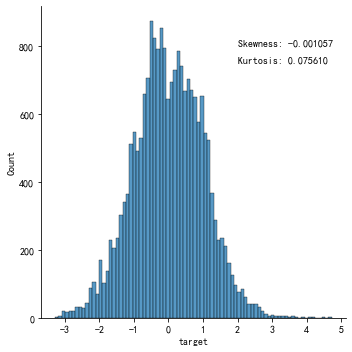

In [5]:
# 使用yeo-johnson对target进行处理，使target的分布符合正态分布，为什么使用yeo-johnson我会在下一次开会讲
pt_tr = PowerTransformer(method="yeo-johnson")

tr["target"] = pt_tr.fit_transform(np.array(tr['target']).reshape(-1,1))
plt.figure(figsize=[20, 10])
sns.displot(tr['target'])
plt.text(2, 800, "Skewness: %f" % tr['target'].skew())
plt.text(2, 750, "Kurtosis: %f" % tr['target'].kurt())
plt.savefig(root2 / "b.jpg")

In [7]:
# # 使用众数填补缺省值
sFea = {}
data_df_all = pd.concat([tr, te], axis=0)
cx = data_df_all.groupby("车系 id")
for a, b in cx:
    sFea[a] = list(set(b["车型 id"]))

for cx_idx in sFea:
    for cxing_idx in sFea[cx_idx]:
        df = data_df_all[(data_df_all["车系 id"]==cx_idx) & (data_df_all["车型 id"]==cxing_idx)]
        for _ in df:
            if _ == "target":
                continue
            a = df[_].value_counts()
            if len(a) <= 0:
                continue
            b = a.index[0]
            tr[_] = tr[_].fillna(b)
            te[_] = te[_].fillna(b)

for _ in tr:
    tr[_] = tr[_].fillna(tr[_].value_counts().index[0])

for _ in te:
    te[_] = te[_].fillna(te[_].value_counts().index[0])

In [8]:
# ******************构造新特征********************
class FeatureEngine:
    def __init__(self):
        self.ID = defaultdict(lambda: defaultdict(int))
        self.sFea = {}
        self.target_cxx = defaultdict(lambda: defaultdict(int))
        
    @staticmethod
    def add2list(pos, name, stage="train"):
        if stage == "train":
            index2name.insert(pos, name)
            numerical.append(name)
    
    @staticmethod
    def add2list_cat(pos, name, stage="train"):
        if stage == "train":
            index2name.insert(pos, name)
            category.append(name)
    
    # strongFea没啥用，忽略
    def strongFea(self, data_df, stage):
        if stage == "train":
            cx = tr.groupby("车系 id")
            for a, b in cx:
                self.sFea[a] = list(set(b["车型 id"]))
    
            for cx_idx in self.sFea:
                for cxing_idx in self.sFea[cx_idx]:
                    if len(data_df[(data_df["车系 id"]==cx_idx) & (data_df["车型 id"]==cxing_idx)]) <= 5:
                        self.target_cxx[cx_idx][cxing_idx] = 0
                    else:
                        self.target_cxx[cx_idx][cxing_idx] = float(data_df[(data_df["车系 id"]==cx_idx) & (data_df["车型 id"]==cxing_idx)]["target"].mean())
            
        data_df.insert(len(data_df.columns)-1, "车系车型_mean", data_df.apply(lambda x: self.target_cxx[x["车系 id"]][x["车型 id"]], axis=1))
        data_df["车系车型_mean"] = data_df["车系车型_mean"].fillna(data_df["车系车型_mean"].mean())
        self.add2list(len(index2name)-1, "车系车型_mean", stage)
    
    # 下面一系列的get函数是类似的，按照某个特征进行聚类，然后求mean，count，max......
    def getMean(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_mean"][list(set(v[fea_name]))[0]] = v["target"].mean()
            data_df.insert(len(data_df.columns)-1, fea_name+"_mean", data_df[fea_name].map(self.ID[fea_name+"_mean"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_mean", data_df[fea_name].map(self.ID[fea_name+"_mean"]))
            data_df[fea_name+"_mean"] = data_df[fea_name+"_mean"].fillna(data_df[fea_name+"_mean"].mean())
        self.add2list(len(index2name)-1, fea_name+"_mean", stage)
    
    
    def getCount(self, data_df, fea_name, stage):
        if stage == "train":
            self.ID[fea_name+"_count"] = dict(data_df[fea_name].value_counts())
            data_df.insert(len(data_df.columns)-1, fea_name+"_count", data_df[fea_name].map(self.ID[fea_name+"_count"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_count", data_df[fea_name].map(self.ID[fea_name+"_count"]))
            data_df[fea_name+"_count"] = data_df[fea_name+"_count"].fillna(data_df[fea_name+"_count"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_count", stage)
    
    
    def getMax(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_max"][list(set(v[fea_name]))[0]] = v["target"].max()
            data_df.insert(len(data_df.columns)-1, fea_name+"_max", data_df[fea_name].map(self.ID[fea_name+"_max"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_max", data_df[fea_name].map(self.ID[fea_name+"_max"]))
            data_df[fea_name+"_max"] = data_df[fea_name+"_max"].fillna(data_df[fea_name+"_max"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_max", stage)
    
    
    def getMin(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_min"][list(set(v[fea_name]))[0]] = v["target"].min()
            data_df.insert(len(data_df.columns)-1, fea_name+"_min", data_df[fea_name].map(self.ID[fea_name+"_min"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_min", data_df[fea_name].map(self.ID[fea_name+"_min"]))
            data_df[fea_name+"_min"] = data_df[fea_name+"_min"].fillna(data_df[fea_name+"_min"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_min", stage)
    
    
    def getMedian(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_median"][list(set(v[fea_name]))[0]] = v["target"].median()
            data_df.insert(len(data_df.columns)-1, fea_name+"_median", data_df[fea_name].map(self.ID[fea_name+"_median"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_median", data_df[fea_name].map(self.ID[fea_name+"_median"]))
            data_df[fea_name+"_median"] = data_df[fea_name+"_median"].fillna(data_df[fea_name+"_median"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_median", stage)
    
    
    def getSum(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_sum"][list(set(v[fea_name]))[0]] = v["target"].sum()
            data_df.insert(len(data_df.columns)-1, fea_name+"_sum", data_df[fea_name].map(self.ID[fea_name+"_sum"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_sum", data_df[fea_name].map(self.ID[fea_name+"_sum"]))
            data_df[fea_name+"_sum"] = data_df[fea_name+"_sum"].fillna(data_df[fea_name+"_sum"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_sum", stage)
    
    
    def getStd(self, data_df, fea_name, stage):
        if stage == "train":
            cs = data_df.loc[:, [fea_name, "target"]]
            cs = cs.groupby(fea_name)
            for k, v in cs:
                self.ID[fea_name+"_std"][list(set(v[fea_name]))[0]] = v["target"].std()
            data_df.insert(len(data_df.columns)-1, fea_name+"_std", data_df[fea_name].map(self.ID[fea_name+"_std"]))
        else:
            data_df.insert(len(data_df.columns)-1, fea_name+"_std", data_df[fea_name].map(self.ID[fea_name+"_std"]))
            data_df[fea_name+"_std"] = data_df[fea_name+"_std"].fillna(data_df[fea_name+"_std"].value_counts().index[0])
        self.add2list(len(index2name)-1, fea_name+"_std", stage)
        
    def newFeature(self, data_df, stage="train"):
        # 构造特征
        pd.set_option('mode.use_inf_as_na', True)

        data_df.insert(len(data_df.columns)-1,"展销是否为假期",data_df["展销时间"].map(lambda x: is_holiday(x)))
        self.add2list_cat(len(index2name)-1, "展销是否为假期", stage)
        
        data_df.insert(len(data_df.columns)-1,"是否转户", data_df["过户次数"].map(lambda x: int(x > 0)))
        # self.add2list(len(index2name)-1, "是否转户", stage)
        # self.add2list_cat(len(index2name)-1, "是否转户", stage)
        
        data_df.insert(len(data_df.columns)-1, "注册年份", data_df["注册日期"].map(lambda x: x.year))
        self.add2list(len(index2name)-1, "注册年份", stage)

        data_df.insert(len(data_df.columns)-1, "Feature_12_num_sqrt", data_df["Feature_12"].map(lambda x: eval(x) ** (1./3.)))
        self.add2list(len(index2name)-1, "Feature_12_num_sqrt", stage)

        data_df.insert(len(data_df.columns)-1, "Feature_12_0", data_df["Feature_12"].map(lambda x: int(x.split('*')[0])))
        self.add2list(len(index2name)-1, "Feature_12_0", stage)

        data_df.insert(len(data_df.columns)-1, "Feature_12_1", data_df["Feature_12"].map(lambda x: int(x.split('*')[1])))
        self.add2list(len(index2name)-1, "Feature_12_1", stage)

        data_df.insert(len(data_df.columns)-1, "Feature_12_2", data_df["Feature_12"].map(lambda x: int(x.split('*')[2])))
        self.add2list(len(index2name)-1, "Feature_12_2", stage)
        
        data_df.insert(len(data_df.columns)-1, "汽车年龄", (data_df["展销时间"] - data_df["上牌日期"]).map(lambda x: x.days))
        # self.add2list(len(index2name)-1, "汽车年龄", stage)


        self.getSum(data_df, "车辆所在城市 id", stage)
        
        self.getMean(data_df, "品牌 id", stage)
        self.getCount(data_df, "品牌 id", stage)
        self.getMax(data_df, "品牌 id", stage)
        self.getMin(data_df, "品牌 id", stage)
        self.getMedian(data_df, "品牌 id", stage)
        self.getSum(data_df, "品牌 id", stage)
        
        # self.getMean(data_df, "是否转户", stage)
        self.getMean(data_df, "厂商类型", stage)
        self.getMean(data_df, "排量", stage)
        # self.getMean(data_df, "燃油类型", stage)
        self.getMean(data_df, "国标码", stage)
        self.getMean(data_df, "年款", stage)
        self.getMean(data_df, "变速箱", stage)
        self.getMean(data_df, "Feature_2", stage)
        
        # self.getMean(data_df, "Feature_6", stage)
        self.getMean(data_df, "Feature_8", stage)
        # self.getMean(data_df, "Feature_9", stage)
        # self.getMean(data_df, "展销是否为假期", stage)
        # self.getCount(data_df, "车型 id", stage)
        
        data_df["新车价"] = np.log(data_df["新车价"])
        data_df.insert(len(data_df.columns)-1, "评估方法1", np.log(data_df.apply(lambda x: x["新车价"] * (0.15 + 0.85*(1 - 0.11*min(3, max(0., x["汽车年龄"] / 365)) - 0.1 * min(4., max(0, x["汽车年龄"] / 365-3)) - 0.09 * min(4., max(0, x["汽车年龄"] / 365-7)))), axis=1)))
        self.add2list(len(index2name)-1, "评估方法1", stage)
        # data_df.insert(len(data_df.columns)-1, "评估方法2", np.log(data_df.apply(lambda x: x["新车价"] * (15 - 5 * min(6, max(0, x["里程"])) / 6 - 4 * min(6, max(0, x["里程"]-6)) / 6 - 3 * min(6, max(0, x["里程"]-12)) / 6 - 2 * min(6, max(0, x["里程"]-18)) / 6 - min(6, max(0, x["里程"]-24)) / 6) / 15, axis=1)))
        # self.add2list(len(index2name)-1, "评估方法2", stage)
        # data_df["评估方法2"].fillna(data_df["评估方法1"], inplace=True)
        
    
    def crossFeature(self, data_df, stage="train"):
        # 特征交叉
        for f1 in data_df:
            for f2 in data_df:
                if f1 != f2 and f1 in cross_num and f2 in cross_num and (f2+'_'+f1) not in index2name:
                    data_df.insert(len(data_df.columns)-1, f1+'_'+f2, (data_df[f1] - data_df[f1].mean()) / data_df[f1].std() * data_df[f2].mean()/ data_df[f2].std()) 
                    self.add2list(len(index2name)-1, f1+'_'+f2, stage)

In [12]:
# 生成新特征
FE = FeatureEngine()
FE.newFeature(tr, "train")
FE.newFeature(te, "test")
# FE.crossFeature(tr, "train")
# FE.crossFeature(te, "test")

# 取出numerical特征和categories特征
tr_x = tr.iloc[:, :-1]
tr_y = tr.iloc[:, -1:]
te_x = te

tr_x_num = tr[numerical].astype("float")
te_x_num = te[numerical].astype("float")
tr_x_cat = tr[category]
te_x_cat = te[category]

# 特征归一化： (x-min) / (max-min)
for _ in tr_x_num:
    if not _ in ["厂商类型", "载客人数", "Feature_8", "是否转户"]:
        min_ = tr_x_num[_].min()
        max_ = tr_x_num[_].max()
        tr_x_num[_] = (tr_x_num[_] - min_) / (max_ - min_)
        te_x_num[_] = (te_x_num[_] - min_) / (max_ - min_)

tr_x_num_array = np.array(tr_x_num)
tr_y_array = np.array(tr_y)
te_x_num_array = np.array(te_x_num)

In [10]:
# 取出numerical特征和categories特征
tr_x = tr.iloc[:, :-1]
tr_y = tr.iloc[:, -1:]
te_x = te.iloc[:, :-1]
te_y = te.iloc[:, -1:]
tr_x_num = tr[numerical].astype("float")
te_x_num = te[numerical].astype("float")
tr_x_cat = tr[category]
te_x_cat = te[category]

# 特征归一化： (x-min) / (max-min)
for _ in tr_x_num:
    if not _ in ["厂商类型", "载客人数", "Feature_8", "是否转户"]:
        min_ = tr_x_num[_].min()
        max_ = tr_x_num[_].max()
        tr_x_num[_] = (tr_x_num[_] - min_) / (max_ - min_)
        te_x_num[_] = (te_x_num[_] - min_) / (max_ - min_)

tr_x_num_array = np.array(tr_x_num)
tr_y_array = np.array(tr_y)
te_x_num_array = np.array(te_x_num)
te_y_array = np.array(te_y)

<AxesSubplot:>

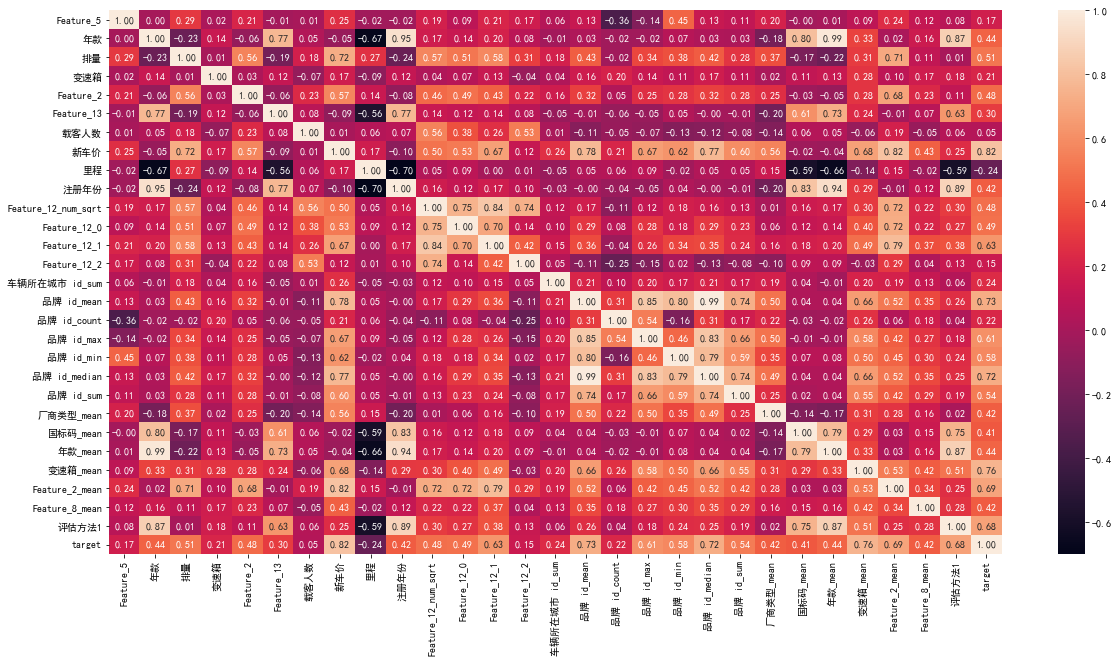

In [15]:
# 协方差矩阵热力图
plt.figure(figsize=(20,10))
tr_num = pd.concat([tr_x_num, tr_y], axis=1)
sns.heatmap(tr_num.corr(), annot=True, fmt='.2f')

In [11]:
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from pprint import pprint

In [14]:
lgb_params = {"num_leaves": 256, "reg_alpha": 0., "reg_lambda": 0.01, "objective": 'mse', "max_depth": -1, 
              "learning_rate": 0.03, "min_child_samples": 25,  "n_estimators": 2000, "subsample": 0.7, "colsample_bytree": 0.45}
xgb_params = {'learning_rate': 0.09995869693725284,
              'subsample': 0.869693514217955,
              'colsample_bytree': 0.9999236721373504,
              'lambda': 0.19406502844686765,
              'alpha': 0.07701113887171819,
              'n_estimators': 2000}
cat_params = {'n_estimators': 1000,
              # 'score_function': 'NewtonL2',
              "min_child_samples": 25,
              'learning_rate':0.03,
              'loss_function':'RMSE',
              'verbose': False,
              'l2_leaf_reg': 0.01,
              'task_type': 'CPU'}

from sklearn.metrics import r2_score, mean_squared_error
from sklearn_tuner import sklearn_tuner
from sklearn.metrics import mean_absolute_error

xgb_cfg = [
    {'name' : "learning_rate", 'type' : 'num', 'lb' : 0.01, 'ub' : 0.1},
    {'name' : "subsample", 'type' : 'num', 'lb' : 0.3, 'ub' : 1.0},
    {'name' : "colsample_bytree", 'type' : 'num', 'lb' : 0.1, 'ub' : 1.0},
    {'name' : "lambda", 'type' : 'num', 'lb' : 0, 'ub' : 0.2},
    {'name' : "alpha", 'type' : 'num', 'lb' : 0, 'ub' : 0.2},
    {'name' : "max_depth", 'type' : 'int', 'lb' : 10, 'ub' : 50},
    {'name' : "min_child_weight", 'type' : 'int', 'lb' : 1, 'ub' : 10},
    {'name' : "n_estimators", 'type' : 'int', 'lb' : 500, 'ub' : 2000},
    ]

lgb_cfg = [
    {'name' : "learning_rate", 'type' : 'num', 'lb' : 0.01, 'ub' : 0.1},
    {'name' : "subsample", 'type' : 'num', 'lb' : 0.3, 'ub' : 1.0},
    {'name' : "colsample_bytree", 'type' : 'num', 'lb' : 0.1, 'ub' : 1.0},
    {'name' : "reg_lambda", 'type' : 'num', 'lb' : 0, 'ub' : 0.2},
    {'name' : "reg_alpha", 'type' : 'num', 'lb' : 0, 'ub' : 0.2},
    {'name' : "num_leaves", 'type' : 'int', 'lb' : 100, 'ub' : 500},
    {'name' : "max_depth", 'type' : 'int', 'lb' : 10, 'ub' : 50},
    {'name' : "n_estimators", 'type' : 'int', 'lb' : 500, 'ub' : 2000},
    ]

cat_cfg = [
    {'name' : "learning_rate", 'type' : 'num', 'lb' : 0.01, 'ub' : 0.1},
    {'name' : "l2_leaf_reg", 'type' : 'int', 'lb' : 1, 'ub' : 10},
    {'name' : "max_depth", 'type' : 'int', 'lb' : 5, 'ub' : 10},
    {'name' : "n_estimators", 'type' : 'int', 'lb' : 500, 'ub' : 2000},
    {'name' : "min_child_samples", 'type' : 'int', 'lb' : 5, 'ub' : 30},
    ]

lgbParams = sklearn_tuner(LGBMRegressor, lgb_cfg, tr_x_num_array, tr_y_array.ravel(), metric = mean_squared_error, max_iter = 25, greater_is_better = False)
catParams = sklearn_tuner(CatBoostRegressor, cat_cfg, tr_x_num_array, tr_y_array.ravel(), metric = mean_squared_error, max_iter = 25, greater_is_better = False)
xgbParams = sklearn_tuner(XGBRegressor, xgb_cfg, tr_x_num_array, tr_y_array.ravel(), metric = mean_squared_error, max_iter = 25, greater_is_better = False)

for _ in xgb_params:
    if _ not in xgbParams:
        xgbParams[_] = xgb_params[_]

for _ in lgb_params:
    if _ not in lgbParams:
        lgbParams[_] = lgb_params[_]

for _ in cat_params:
    if _ not in catParams:
        catParams[_] = cat_params[_]

In [12]:
# 优化结果：模型参数(使用hebo进行参数优化，因为一次优化的时间消耗大，因此将优化结果存了下来)
lgbParams = {'learning_rate': 0.010035982594961306, 'subsample': 0.35028462644730735, 'colsample_bytree': 0.3796965007412236, 'reg_lambda': 0.0006865914755758266, 'reg_alpha': 0.0026163019185854106, 'num_leaves': 189, 'max_depth': 37, 'n_estimators': 1965, 'objective': 'mse', 'min_child_samples': 25}
xgbParams = {'learning_rate': 0.010211967985703159, 'subsample': 0.30001115463199896, 'colsample_bytree': 0.48460986059028555, 'lambda': 0.032780563044634864, 'alpha': 0.06981554843421037, 'max_depth': 26, 'min_child_weight': 10, 'n_estimators': 1845}
catParams = {'learning_rate': 0.08491056514750207, 'l2_leaf_reg': 1, 'max_depth': 8, 'n_estimators': 2000, 'min_child_samples': 25, 'loss_function': 'RMSE', 'verbose': False, 'task_type': 'CPU'}

In [14]:
from xgboost import plot_importance
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
model_XGB = XGBRegressor(**xgbParams, importance_type="weight").fit(tr_x_num, tr_y.target)
thresholds = sort(model_XGB.feature_importances_)
f_i = dict(zip(numerical, model_XGB.feature_importances_))
f_i = sorted(f_i.items(), key=lambda x: x[1])
print(f_i)

[('载客人数', 0.0030554247), ('厂商类型_mean', 0.0052583995), ('Feature_8_mean', 0.008220348), ('国标码_mean', 0.008516124), ('Feature_2_mean', 0.010219628), ('Feature_2', 0.014639529), ('品牌 id_median', 0.015507326), ('品牌 id_sum', 0.01569428), ('年款_mean', 0.016866222), ('品牌 id_min', 0.019530999), ('品牌 id_max', 0.020737823), ('排量', 0.021512141), ('变速箱_mean', 0.022785934), ('品牌 id_mean', 0.025393508), ('品牌 id_count', 0.025605574), ('年款', 0.025747882), ('变速箱', 0.027470918), ('注册年份', 0.032192178), ('Feature_5', 0.035974484), ('Feature_12_1', 0.042471796), ('车辆所在城市 id_sum', 0.051318575), ('Feature_12_2', 0.05206639), ('Feature_12_0', 0.05615424), ('Feature_12_num_sqrt', 0.058421392), ('Feature_13', 0.06207116), ('新车价', 0.08711169), ('里程', 0.11511417), ('评估方法1', 0.120341875)]


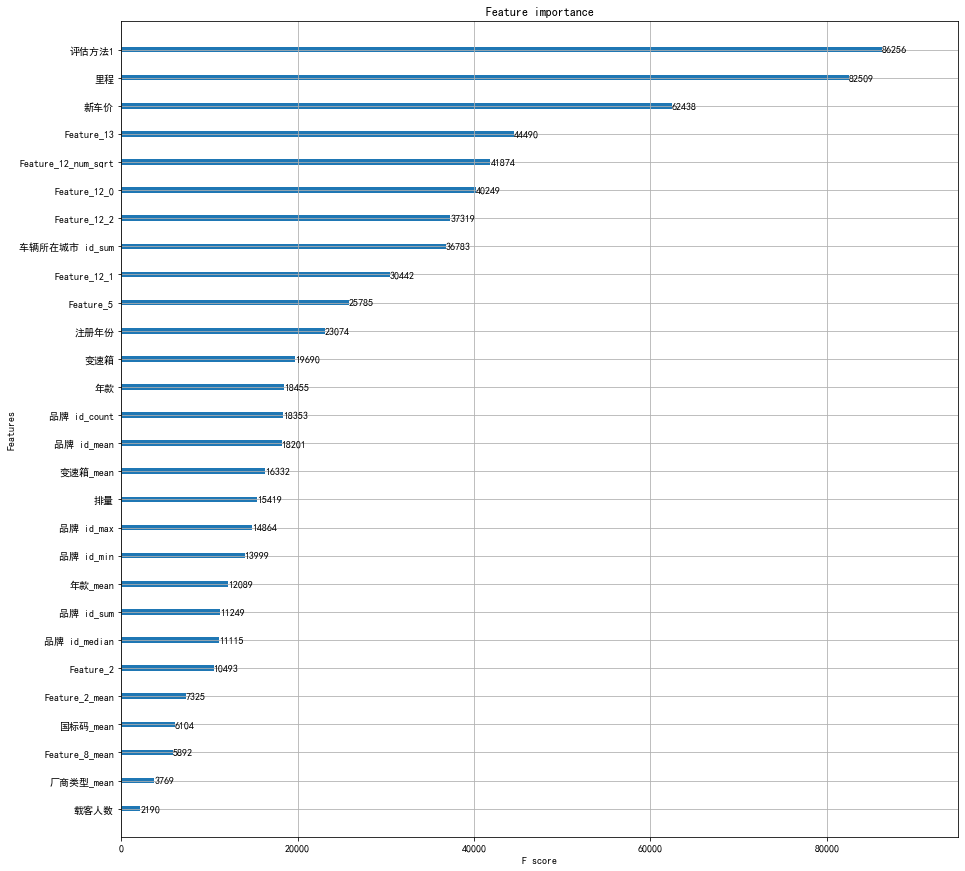

In [20]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model_XGB, importance_type="weight", ax=ax)
plt.show()

In [14]:
for name, thresh in f_i:
  # select features using threshold
    selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(tr_x_num)
  # train model
    selection_model = XGBRegressor(**xgbParams)
    selection_model.fit(select_X_train, tr_y.target)
  # eval model
    select_X_test = selection.transform(te_x_num)
    y_pred = selection_model.predict(select_X_test)
    accuracy = metric(pt_tr.inverse_transform(y_pred.reshape(-1, 1)), te_y[["target"]])
    print("Feature Name=%s Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (name, thresh, select_X_train.shape[1], accuracy*100.0))

Feature Name=载客人数 Thresh=0.003, n=28, Accuracy: 52.78%
Feature Name=厂商类型_mean Thresh=0.005, n=27, Accuracy: 52.29%
Feature Name=Feature_8_mean Thresh=0.008, n=26, Accuracy: 52.22%
Feature Name=国标码_mean Thresh=0.009, n=25, Accuracy: 52.58%
Feature Name=Feature_2_mean Thresh=0.010, n=24, Accuracy: 52.18%
Feature Name=Feature_2 Thresh=0.015, n=23, Accuracy: 52.41%


KeyboardInterrupt: 

In [15]:
Regressor = {
             "Xgboost": XGBRegressor(**xgbParams),
             "Catboost": CatBoostRegressor(**catParams),
             "Lgb": LGBMRegressor(**lgbParams),
}

In [20]:
for _ in Regressor:
    model_trained = Regressor[_].fit(tr_x_num, tr_y.target)
    y_predict = model_trained.predict(te_x_num)
    print("{}: {}".format(_,  metric(pt_tr.inverse_transform(y_predict.reshape(-1, 1)), te_y[["target"]])))

Xgboost: 0.5285938142927857
Catboost: 0.5304146654087263
Lgb: 0.5256167264959078


In [15]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
import numpy as np
 
# stacking
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
 
    # 将原来的模型clone出来，并且进行实现fit功能
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
 
        #对于每个模型，使用交叉验证的方法来训练初级学习器，并且得到次级训练集
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                self.base_models_[i].append(instance)
                out_of_fold_predictions[holdout_index, i] = y_pred
 
        # 使用次级训练集来训练次级学习器
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
 
    #在上面的fit方法当中，我们已经将我们训练出来的初级学习器和次级学习器保存下来了
    #predict的时候只需要用这些学习器构造我们的次级预测数据集并且进行预测就可以了
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

base_models = [
               CatBoostRegressor(**catParams),
               LGBMRegressor(**lgbParams),
               XGBRegressor(**xgbParams),
              ]

meta_model = LinearRegression()
stacking_model = StackingAveragedModels(base_models=base_models, meta_model=meta_model)

stacking_model.fit(tr_x_num_array, tr_y_array.ravel())
y_predict = stacking_model.predict(te_x_num_array)

In [16]:
print("stacking model: {}".format(metric(pt_tr.inverse_transform(y_predict.reshape(-1, 1)), te_y[["target"]])))
# target    0.908153
# dtype: float64 target    0.437
# dtype: float64
# stacking model: 0.5312306398740904
# 0.5320433
# stacking model: 0.5330273981284721

stacking model: 0.5311928846204009


In [19]:
pred = pt_tr.inverse_transform(y_predict.reshape(-1, 1))

In [20]:
pred

array([[16.93470974],
       [ 9.35557855],
       [ 2.54802488],
       ...,
       [ 6.27195366],
       [ 2.41555627],
       [12.61822139]])

In [21]:
ans = pd.DataFrame({"id": te["车辆 id"], "pred": pred.ravel()})
ans.head()

,id,pred
0,3,16.934710
1,4,9.355579
2,8,2.548025
3,9,6.378146
4,11,15.586146


In [22]:
ans.to_csv("附件3：估价模型结果.txt", sep='\t', index=False, header=None)